#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [245]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, GridSearchCV

In [246]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [247]:
data = pd.read_csv('/content/drive/MyDrive/KT Aivle/Mini Project 3/data01_train.csv')

In [248]:
data.drop('subject', axis = 1, inplace = True)

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [249]:
Activity_dynamic = {
    'STANDING' : 0,
    'SITTING' : 0,
    'LAYING' : 0,
    'WALKING' : 1,
    'WALKING_UPSTAIRS' : 1,
    'WALKING_DOWNSTAIRS' : 1
}
data['Activity_dynamic'] = data['Activity'].replace(Activity_dynamic)

In [250]:
# x, y로 나누기
y = data.loc[:, 'Activity_dynamic']
x = data.drop(['Activity', 'Activity_dynamic'], axis=1)

In [251]:
# train과 validation 분할 수행
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state=1)

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

→ 파일 2에서 가장 성능 좋게 나왔던 XGBoost, LightGBM 이용하겠음

#### 1) 알고리즘1 : XGBoost

In [252]:
#!pip install xgboost

In [253]:
## 하이퍼 파라미터 튜닝 없이
# from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_train_le = le.fit_transform(y_train)
# y_val_le = le.transform(y_val)

# model = XGBClassifier(random_state=1)
# model.fit(x_train.values, y_train_le)

# # y_pred = model.predict(x_val)

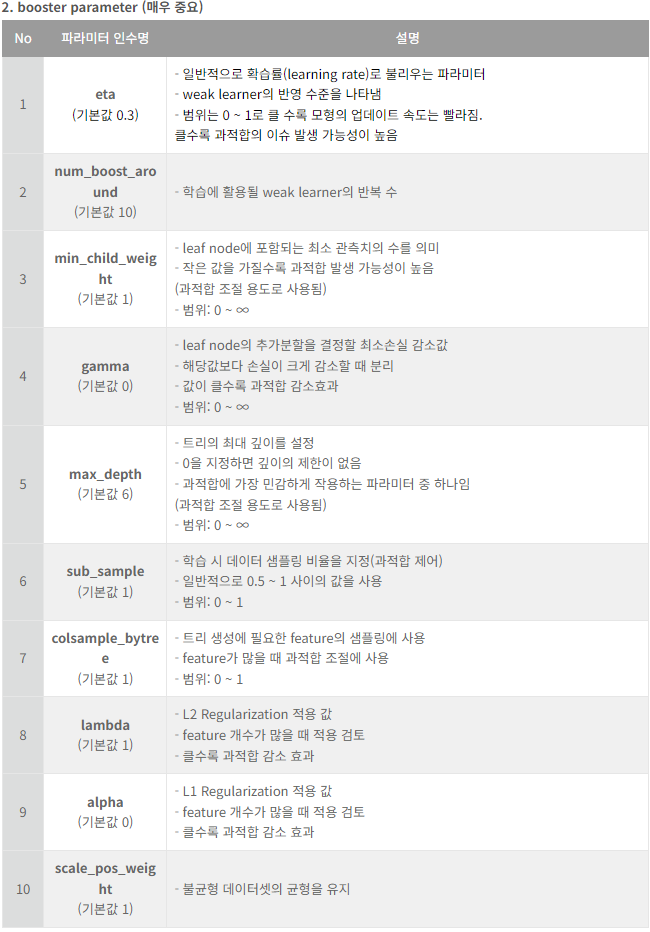

In [254]:
# 하이퍼 파라미터 튜닝
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_val_le = le.transform(y_val)

model = XGBClassifier(random_state=1)
param_grid = {
    'n_estimators': [20, 30, 50],  # Number of boosting rounds
    'learning_rate': [0.001, 0.005, 0.01, 0.03],  # Step size shrinkage used in update to prevent overfitting
    'max_depth': [2, 3, 4],  # Maximum depth of a tree
    'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child
    #'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
    #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
    #'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_result = grid_search.fit(x_train.values, y_train_le)

best_model = grid_result.best_estimator_
y_pred = best_model.predict(x_val)

KeyboardInterrupt: 

In [ ]:
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

In [ ]:
print('accuracy :',accuracy_score(y_val_le, y_pred))
print('='*60)
print(confusion_matrix(y_val_le, y_pred))
print('='*60)
print(classification_report(y_val_le, y_pred))

In [ ]:
# 성능 예측
cv_score = cross_val_score(model, x_train.values, y_train_le, cv=10, scoring='accuracy')

In [ ]:
# 결과 확인
print(cv_score)
print(cv_score.mean())

#### 2) 알고리즘2 : LightGBM

In [ ]:
#!pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=1, verbose = -1)

param_grid = {
    'n_estimators': [20, 50, 70, 100],
    'learning_rate': [0.001, 0.005, 0.01],
    'max_depth': [2, 3, 5],
    'min_child_samples': [5, 10, 20],
}

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_result = grid_search.fit(x_train.values, y_train_le)

# Predict on validation set with best model
best_model = grid_result.best_estimator_
y_pred = best_model.predict(x_val)

model.fit(x_train.values, y_train)

y_pred = model.predict(x_val)

In [ ]:
best_params = grid_result.best_params_
print("Best Parameters:", best_params)

In [ ]:
print('accuracy :',accuracy_score(y_val, y_pred))
print('='*60)
print(confusion_matrix(y_val, y_pred))
print('='*60)
print(classification_report(y_val, y_pred))

In [ ]:
# 성능 예측
cv_score = cross_val_score(model, x_train.values, y_train, cv=10, scoring='accuracy')

In [ ]:
# 결과 확인
print(cv_score)
print(cv_score.mean())

[1.         0.99757282 1.         1.         1.         0.99757282
 1.         1.         1.         1.        ]
0.9995145631067961


→ 미세하지만 LightGBM이 더 성능 좋음

#### 3) 알고리즘3 : 딥러닝

In [255]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers import Adam

In [256]:
# !pip install keras-tuner
# import keras_tuner as kt

In [257]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [258]:
n = x_train.shape[1]
n

561

In [259]:
# 하이퍼 파라미터 튜닝 없이
clear_session()

model = Sequential([ Dense( 256, input_shape = (n ,), activation = 'relu'),
                      Dense( 128, activation = 'relu'),
                      Dense( 64, activation = 'relu'),
                      Dense( 1, activation = 'sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               143872    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 185089 (723.00 KB)
Trainable params: 185089 (723.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [260]:
model.compile( optimizer=Adam(learning_rate= 0.001), loss ='binary_crossentropy')
hist = model.fit(x_train, y_train, epochs = 30, validation_split=.3, verbose=0).history

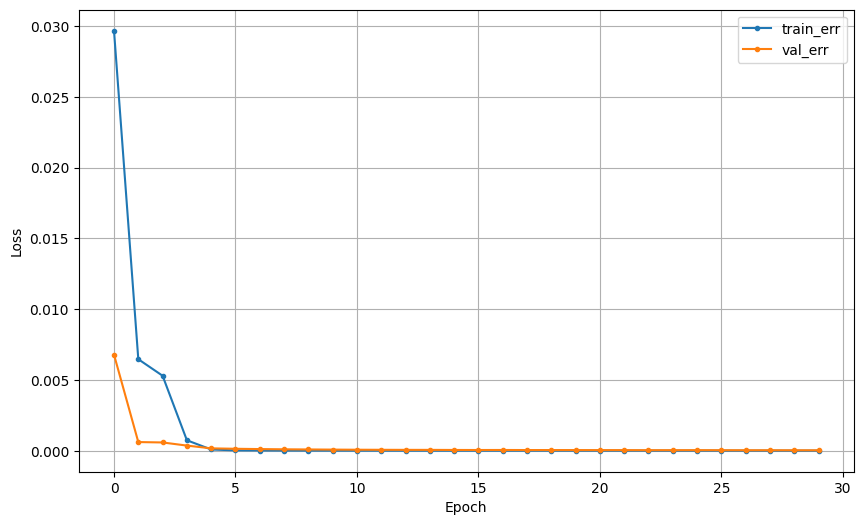

In [261]:
dl_history_plot(hist)

In [262]:
y_pred = model.predict(x_val)
y_pred = np.where(y_pred >= 0.5, 1, 0)

56/56 [==============================] - 1s 10ms/step


In [16]:
# # 하이퍼 파라미터 튜닝
# def build_model(hp):
#     model = Sequential([ Dense(units=hp.Choice('node1', [16, 64, 256]), input_shape = (x_train.shape[1],), activation='relu'),
#                          Dense(units=hp.Choice('node2', [8, 32, 128]), activation='relu'),
#                          Dense(units=hp.Choice('node3', [4, 12, 64]), activation='relu'),
#                          Dense(1), activation = 'sigmoid'])
#     model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate = hp.Choice('learning_rate', [0.0001, 0.001, 0.01])))
#     return model

In [17]:
# %%time
# tuner = kt.GridSearch(build_model, objective='val_loss', project_name='dnn_tuning_p3_1')
# tuner.search(x_train, y_train, epochs = 30, validation_split = .3, verbose=1)
# best_model = tuner.get_best_models(num_models=1)[0]

In [18]:
# tuner.results_summary()

In [ ]:
# y_pred = best_model.predict(x_val, verbose = 0)

# plt.scatter(y_val, y_pred)
# plt.plot(y_val, y_val, color = 'gray', linewidth = .5)
# plt.grid()
# plt.show()

In [19]:
print('accuracy :',accuracy_score(y_val, y_pred))
print('='*60)
print(confusion_matrix(y_val, y_pred))
print('='*60)
print(classification_report(y_val, y_pred))

accuracy : 0.9994334277620397
[[953   1]
 [  0 811]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       954
           1       1.00      1.00      1.00       811

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [263]:
# 모델 저장
dump(model, 'model_0.joblib')

['model_0.joblib']

### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [384]:
static_data = data[data['Activity_dynamic'] == 0].reset_index(drop=True)
x_static = static_data.drop(['Activity', 'Activity_dynamic'], axis=1)
y_static = static_data.loc[:, 'Activity']

In [385]:
x_static_train, x_static_val, y_static_train, y_static_val = train_test_split(x_static, y_static, test_size=.3, random_state=1)

#### 1) 알고리즘1 : XGBoost

In [ ]:
# # 하이퍼 파라미터 튜닝
# from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_static_train_le = le.fit_transform(y_static_train)
# y_static_val_le = le.transform(y_static_val)

# model = XGBClassifier(random_state=1)
# param_grid = {
#     'n_estimators': [50, 100, 150],  # Number of boosting rounds
#     'learning_rate': [0.01, 0.03, 0.05, 0.1],  # Step size shrinkage used in update to prevent overfitting
#     'max_depth': [4, 8, 16],  # Maximum depth of a tree
#     'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child
#     #'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
#     #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
#     #'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# grid_result = grid_search.fit(x_static_train.values, y_static_train_le)

# best_model = grid_result.best_estimator_
# y_static_pred = best_model.predict(x_static_val)

In [ ]:
# best_params = grid_result.best_params_
# print("Best Parameters:", best_params)

Best Parameters: {'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 50}


In [ ]:
# 하이퍼 파라미터 튜닝 없이
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_static_train_le = le.fit_transform(y_static_train)
y_static_val_le = le.transform(y_static_val)

model = XGBClassifier(random_state=1)
model.fit(x_static_train.values, y_static_train_le)

y_static_pred = model.predict(x_static_val)

In [ ]:
print('accuracy :',accuracy_score(y_static_val_le, y_static_pred))
print('='*60)
print(confusion_matrix(y_static_val_le, y_static_pred))
print('='*60)
print(classification_report(y_static_val_le, y_static_pred))

accuracy : 0.9706336939721792
[[204   0   0]
 [  0 207  13]
 [  0   6 217]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       204
           1       0.97      0.94      0.96       220
           2       0.94      0.97      0.96       223

    accuracy                           0.97       647
   macro avg       0.97      0.97      0.97       647
weighted avg       0.97      0.97      0.97       647



In [ ]:
# 성능 예측
cv_score = cross_val_score(model, x_static_train.values, y_static_train_le, cv=10, scoring='accuracy')

In [ ]:
# 결과 확인
print(cv_score)
print(cv_score.mean())

[0.99227799 0.98069498 0.98069498 0.96911197 0.96911197 0.98069498
 0.98841699 0.98837209 0.98449612 0.98837209]
0.982224417108138


#### 2) 알고리즘2 : LightGBM

In [ ]:
# # 하이퍼 파라미터 튜닝
# from lightgbm import LGBMClassifier

# model = LGBMClassifier(random_state=1, verbose = -1)

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'min_child_samples': [10, 20, 30],
# }

# # Grid search with cross-validation
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# grid_result = grid_search.fit(x_static_train.values, y_static_train_le)

# # Predict on validation set with best model
# best_model = grid_result.best_estimator_
# y_static_pred = best_model.predict(x_static_val)

# model.fit(x_static_train.values, y_static_train)

# y_static_pred = model.predict(x_static_val)

In [ ]:
# best_params = grid_result.best_params_
# print("Best Parameters:", best_params)

In [386]:
# 하이퍼 파라미터 튜닝 없이
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=1, verbose = -1)
model.fit(x_static_train.values, y_static_train)

y_static_pred = model.predict(x_static_val)

In [387]:
print('accuracy :',accuracy_score(y_static_val, y_static_pred))
print('='*60)
print(confusion_matrix(y_static_val, y_static_pred))
print('='*60)
print(classification_report(y_static_val, y_static_pred))

accuracy : 0.98043254376931
[[320   0   0]
 [  0 307  10]
 [  0   9 325]]
              precision    recall  f1-score   support

      LAYING       1.00      1.00      1.00       320
     SITTING       0.97      0.97      0.97       317
    STANDING       0.97      0.97      0.97       334

    accuracy                           0.98       971
   macro avg       0.98      0.98      0.98       971
weighted avg       0.98      0.98      0.98       971



In [364]:
# 성능 예측
cv_score = cross_val_score(model, x_static_train.values, y_static_train, cv=10, scoring='accuracy')

KeyboardInterrupt: 

In [ ]:
# 결과 확인
print(cv_score)
print(cv_score.mean())

[0.98841699 0.98455598 0.98455598 0.98455598 0.97683398 0.98455598
 0.98841699 0.98837209 0.99224806 0.99224806]
0.9864760108946156


#### 3) 알고리즘3 : 딥러닝

In [266]:
y_static_train

569      SITTING
2513      LAYING
2227     SITTING
492      SITTING
961     STANDING
          ...   
2763      LAYING
905       LAYING
1096      LAYING
235     STANDING
1061     SITTING
Name: Activity, Length: 2263, dtype: object

In [267]:
from sklearn.preprocessing import LabelEncoder

In [268]:
le = LabelEncoder()
y_static_train = le.fit_transform(y_static_train)
y_static_val = le.transform(y_static_val)
y_static_train

array([1, 0, 1, ..., 0, 2, 1])

In [269]:
# 하이퍼 파라미터 튜닝 없이
clear_session()

model = Sequential([ Dense( 256, input_shape = (n ,), activation = 'relu'),
                      Dense( 128, activation = 'relu'),
                      Dense( 64, activation = 'relu'),
                      Dense( 3, activation = 'softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               143872    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 185219 (723.51 KB)
Trainable params: 185219 (723.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [270]:
model.compile( optimizer=Adam(learning_rate= 0.00005), loss ='sparse_categorical_crossentropy')
hist = model.fit(x_static_train, y_static_train, epochs = 100, validation_split=.3, verbose=0).history

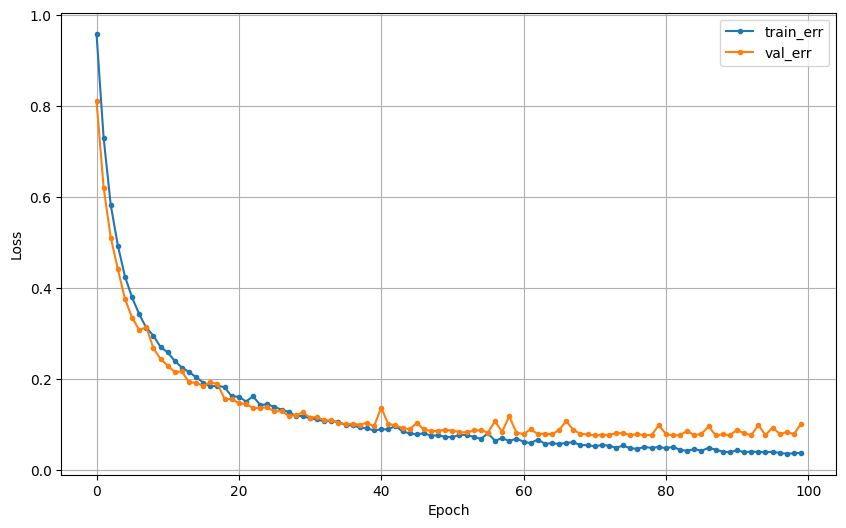

In [271]:
dl_history_plot(hist)

In [272]:
y_static_pred = model.predict(x_static_val)
y_static_pred = np.argmax(y_static_pred, axis=1)

31/31 [==============================] - 0s 2ms/step


In [273]:
print('accuracy :',accuracy_score(y_static_val, y_static_pred))
print('='*60)
print(confusion_matrix(y_static_val, y_static_pred))
print('='*60)
print(classification_report(y_static_val, y_static_pred))

accuracy : 0.9588053553038105
[[320   0   0]
 [  1 285  31]
 [  0   8 326]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       320
           1       0.97      0.90      0.93       317
           2       0.91      0.98      0.94       334

    accuracy                           0.96       971
   macro avg       0.96      0.96      0.96       971
weighted avg       0.96      0.96      0.96       971



In [388]:
# 모델 저장
dump(model, 'model_11.joblib')

['model_11.joblib']

### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [389]:
dynamic_data = data[data['Activity_dynamic'] == 1].reset_index(drop=True)
x_dynamic = dynamic_data.drop(['Activity', 'Activity_dynamic'], axis=1)
y_dynamic = dynamic_data.loc[:, 'Activity']

In [390]:
x_dynamic_train, x_dynamic_val, y_dynamic_train, y_dynamic_val = train_test_split(x_dynamic, y_dynamic, test_size=.3, random_state=1)

#### 1) 알고리즘1 : XGBoost

In [ ]:
# # 하이퍼 파라미터 튜닝
# from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# y_dynamic_train_le = le.fit_transform(y_dynamic_train)
# y_dynamic_val_le = le.transform(y_dynamic_val)

# model = XGBClassifier(random_state=1)
# param_grid = {
#     'n_estimators': [20, 30, 50],  # Number of boosting rounds
#     'learning_rate': [0.001, 0.005, 0.01, 0.03],  # Step size shrinkage used in update to prevent overfitting
#     'max_depth': [2, 3, 4],  # Maximum depth of a tree
#     'min_child_weight': [1, 2, 3],  # Minimum sum of instance weight (hessian) needed in a child
#     #'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition on a leaf node of the tree
#     #'subsample': [0.6, 0.8, 1.0],  # Subsample ratio of the training instances
#     #'colsample_bytree': [0.6, 0.8, 1.0],  # Subsample ratio of columns when constructing each tree
# }

# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# grid_result = grid_search.fit(x_dynamic_train.values, y_dynamic_train_le)

# best_model = grid_result.best_estimator_
# y_dynamic_pred = best_model.predict(x_dynamic_val)

In [ ]:
# best_params = grid_result.best_params_
# print("Best Parameters:", best_params)

In [ ]:
# 하이퍼 파라미터 튜닝 없이
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_dynamic_train_le = le.fit_transform(y_dynamic_train)
y_dynamic_val_le = le.transform(y_dynamic_val)

model = XGBClassifier(random_state=1)
model.fit(x_dynamic_train.values, y_dynamic_train_le)

y_dynamic_pred = model.predict(x_dynamic_val)

In [ ]:
print('accuracy :',accuracy_score(y_dynamic_val_le, y_dynamic_pred))
print('='*60)
print(confusion_matrix(y_dynamic_val_le, y_dynamic_pred))
print('='*60)
print(classification_report(y_dynamic_val_le, y_dynamic_pred))

accuracy : 1.0
[[214   0   0]
 [  0 163   0]
 [  0   0 153]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       214
           1       1.00      1.00      1.00       163
           2       1.00      1.00      1.00       153

    accuracy                           1.00       530
   macro avg       1.00      1.00      1.00       530
weighted avg       1.00      1.00      1.00       530



In [ ]:
# 성능 예측
cv_score = cross_val_score(model, x_dynamic_train.values, y_dynamic_train_le, cv=10, scoring='accuracy')

In [ ]:
# 결과 확인
print(cv_score)
print(cv_score.mean())

[0.98584906 0.99528302 1.         0.98113208 0.99528302 1.
 0.98113208 0.98578199 0.99526066 0.99526066]
0.9914982562818564


#### 2) 알고리즘2 : LightGBM

In [ ]:
# # 하이퍼 파라미터 튜닝
# from lightgbm import LGBMClassifier

# model = LGBMClassifier(random_state=1, verbose = -1)

# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7],
#     'min_child_samples': [10, 20, 30],
# }

# # Grid search with cross-validation
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
# grid_result = grid_search.fit(x_dynamic_train.values, y_dynamic_train_le)

# # Predict on validation set with best model
# best_model = grid_result.best_estimator_
# y_dynamic_pred = best_model.predict(x_dynamic_val)

# model.fit(x_dynamic_train.values, y_dynamic_train)

# y_dynamic_pred = model.predict(x_dynamic_val)

In [ ]:
# best_params = grid_result.best_params_
# print("Best Parameters:", best_params)

In [391]:
# 하이퍼 파라미터 튜닝 없이
from lightgbm import LGBMClassifier

model = LGBMClassifier(random_state=1, verbose = -1)
model.fit(x_dynamic_train.values, y_dynamic_train)

y_dynamic_pred = model.predict(x_dynamic_val)

In [392]:
print('accuracy :',accuracy_score(y_dynamic_val, y_dynamic_pred))
print('='*60)
print(confusion_matrix(y_dynamic_val, y_dynamic_pred))
print('='*60)
print(classification_report(y_dynamic_val, y_dynamic_pred))

accuracy : 0.9974842767295597
[[307   0   0]
 [  1 242   0]
 [  0   1 244]]
                    precision    recall  f1-score   support

           WALKING       1.00      1.00      1.00       307
WALKING_DOWNSTAIRS       1.00      1.00      1.00       243
  WALKING_UPSTAIRS       1.00      1.00      1.00       245

          accuracy                           1.00       795
         macro avg       1.00      1.00      1.00       795
      weighted avg       1.00      1.00      1.00       795



In [ ]:
# 성능 예측
cv_score = cross_val_score(model, x_dynamic_train.values, y_dynamic_train, cv=10, scoring='accuracy')

In [ ]:
# 결과 확인
print(cv_score)
print(cv_score.mean())

[0.99528302 0.99528302 1.         0.98113208 0.99056604 1.
 0.98584906 0.99526066 1.         1.        ]
0.9943373871054279


#### 3) 알고리즘3 : 딥러닝

In [277]:
le = LabelEncoder()
y_dynamic_train = le.fit_transform(y_dynamic_train)
y_dynamic_val = le.transform(y_dynamic_val)
y_dynamic_train

array([1, 0, 0, ..., 2, 1, 2])

In [278]:
# 하이퍼 파라미터 튜닝 없이
clear_session()

model = Sequential([ Dense( 256, input_shape = (n ,), activation = 'relu'),
                      Dense( 128, activation = 'relu'),
                      Dense( 64, activation = 'relu'),
                      Dense( 3, activation = 'softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               143872    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                 195       
                                                                 
Total params: 185219 (723.51 KB)
Trainable params: 185219 (723.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [279]:
model.compile( optimizer=Adam(learning_rate= 0.001), loss ='sparse_categorical_crossentropy')
hist = model.fit(x_dynamic_train, y_dynamic_train, epochs = 30, validation_split=.3, verbose=0).history

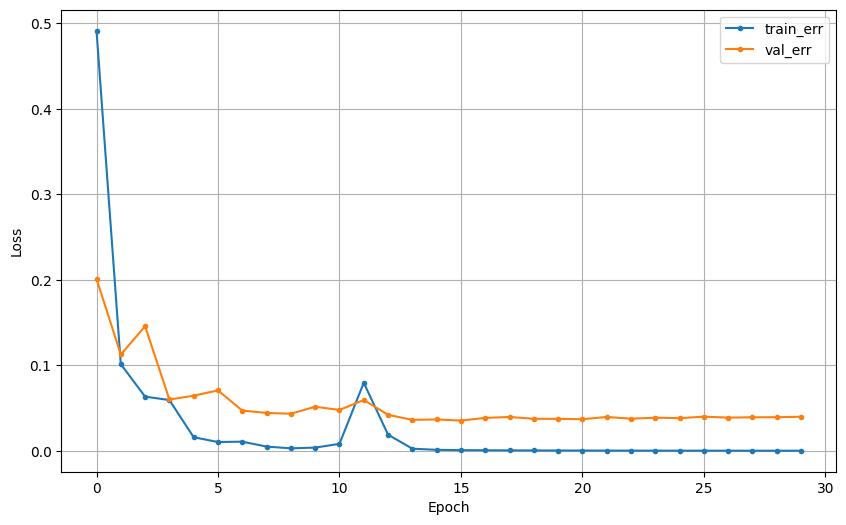

In [280]:
dl_history_plot(hist)

In [281]:
y_dynamic_pred = model.predict(x_dynamic_val)
y_dynamic_pred = np.argmax(y_dynamic_pred, axis=1)

25/25 [==============================] - 0s 3ms/step


In [282]:
print('accuracy :',accuracy_score(y_dynamic_val, y_dynamic_pred))
print('='*60)
print(confusion_matrix(y_dynamic_val, y_dynamic_pred))
print('='*60)
print(classification_report(y_dynamic_val, y_dynamic_pred))

accuracy : 0.9949685534591195
[[307   0   0]
 [  0 240   3]
 [  0   1 244]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      0.99      0.99       243
           2       0.99      1.00      0.99       245

    accuracy                           0.99       795
   macro avg       0.99      0.99      0.99       795
weighted avg       0.99      0.99      0.99       795



In [393]:
# 모델 저장
dump(model, 'model_12.joblib')

['model_12.joblib']

### 성능 결과
1. 정적/동적 행동 분류 모델
- XGBoost(튜닝O) 0.99927
- LightGBM(튜닝O) 0.99951
- 딥러닝(튜닝X) 1

2-1. 정적 세부 분류
- XGBoost(튜닝X) 0.98222
- LightGBM(튜닝X) 0.98647
- 딥러닝(튜닝X) 0.96290

2-2. 동적 세부 분류
- XGBoost(튜닝X) 0.99149
- LightGBM(튜닝X) 0.99433
- 딥러닝(튜닝X) 0.99811

### [선택사항] (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들어서 분류 모델 합치기

In [404]:
def final(model_0, model_11, model_12, new_data):
  # 0. 테스트 데이터 전처리

  new_data.drop('subject', axis = 1, inplace = True)

  Activity_dynamic = {
      'STANDING' : 0,
      'SITTING' : 0,
      'LAYING' : 0,
      'WALKING' : 1,
      'WALKING_UPSTAIRS' : 1,
      'WALKING_DOWNSTAIRS' : 1
  }

  new_data['Activity_dynamic'] = new_data['Activity'].replace(Activity_dynamic)

  # x, y로 나누기
  y_test = new_data.loc[:, ['Activity_dynamic', 'Activity']]
  x_test = new_data.drop(['Activity', 'Activity_dynamic'], axis=1)

  y_pred = model_0.predict(x_test)
  y_pred = np.where(y_pred >= 0.5, 1, 0)

  # 성능평가
  print('accuracy :',accuracy_score(y_pred, y_test['Activity_dynamic']))
  print('='*60)
  print(confusion_matrix(y_pred, y_test['Activity_dynamic']))
  print('='*60)
  print(classification_report(y_pred, y_test['Activity_dynamic']))

  static_x = x_test[y_pred==0]
  dynamic_x = x_test[y_pred==1]
  y_test.drop('Activity_dynamic', axis=1, inplace=True)
  static_y_test = y_test[y_pred==0]
  dynamic_y_test = y_test[y_pred==1]

  static_pred = model_11.predict(static_x)
  dynamic_pred = model_12.predict(dynamic_x)
  # 정답 하나로 합치기
  new_test = np.r_[static_y_test, dynamic_y_test]
  # 예측값도 하나로 합치기
  new_pred = np.r_[static_pred, dynamic_pred]

  # 최종 성능평가
  print('final accuracy :',accuracy_score(new_test, new_pred))
  print('='*60)
  print(confusion_matrix(new_test, new_pred))
  print('='*60)
  print(classification_report(new_test, new_pred))

In [405]:
from joblib import dump, load

In [406]:
new_data = pd.read_csv('/content/drive/MyDrive/KT Aivle/Mini Project 3/data01_test.csv')

In [407]:
# 1. 모델 불러오기
model_0 = load('model_0.joblib')
# 1. 정적 분류 모델
model_11 = load('model_11.joblib')
# 2. 동적 분류 모델
model_12 = load('model_12.joblib')

In [408]:
final(model_0, model_11, model_12, new_data)

46/46 [==============================] - 0s 4ms/step
accuracy : 0.9993201903467029
[[832   0]
 [  1 638]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       832
           1       1.00      1.00      1.00       639

    accuracy                           1.00      1471
   macro avg       1.00      1.00      1.00      1471
weighted avg       1.00      1.00      1.00      1471

final accuracy : 0.9850441876274643
[[288   3   0   0   1   0]
 [  0 245   9   0   0   0]
 [  0   7 280   0   0   0]
 [  0   0   0 226   0   2]
 [  0   0   0   0 195   0]
 [  0   0   0   0   0 215]]
                    precision    recall  f1-score   support

            LAYING       1.00      0.99      0.99       292
           SITTING       0.96      0.96      0.96       254
          STANDING       0.97      0.98      0.97       287
           WALKING       1.00      0.99      1.00       228
WALKING_DOWNSTAIRS       0.99      1.00      1.00       195
  WALKI